# Pipeline Flexo — Agregação e Clusterização

Notebook responsável por consolidar os eventos Flexo em uma linha por OP e aplicar um pipeline de clusterização para identificar padrões de produção semelhantes.

## Sumário

1. Setup e carga das bases
2. Preparação e enriquecimento
3. Feature Engineering
4. Seleção de Features para Clusterização
5. Preparação e Normalização dos Dados
6. Determinação do Número Ótimo de Clusters (K)
7. Aplicação do K-Means com K Ótimo
8. Análise de Perfil dos Clusters
9. Visualizações dos Clusters
10. Conclusão e Próximos Passos

In [97]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

pd.set_option("display.max_columns", None)
np.set_printoptions(suppress=True)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Setup e carga das bases

In [98]:
DATA_DIR = Path("../../../data")
RAW_DIR = DATA_DIR / "raw"
ML_DIR = DATA_DIR / "ml"

print("Carregando bases brutas...")
df_facas = pd.read_parquet(RAW_DIR / "tb_facas.parquet")
df_flexo = pd.read_parquet(ML_DIR / "table_final_flexo.parquet")
df_pedidos = pd.read_parquet("tb_pedidos_process.parquet")

print(f"tb_facas: {df_facas.shape}")
print(f"table_final_flexo: {df_flexo.shape}")
print(f"tb_pedidos_process: {df_pedidos.shape}")

Carregando bases brutas...
tb_facas: (8180, 4)
table_final_flexo: (70713, 8)
tb_pedidos_process: (230543, 38)


In [99]:
df_pedidos[sorted(df_pedidos.columns)].columns

Index(['CAT_COMPOSICAO', 'CAT_ESPELHO', 'CAT_FILME', 'CD_FACA', 'CD_ITEM',
       'CD_PEDIDO', 'FL_CONTROLE_ESPECIAL_IMPRESSAO', 'FL_LAP_INTERNO',
       'FL_LAP_NO_COMPR', 'FL_REFILADO', 'FL_RESINAINTERNA',
       'FL_TESTE_EXIGELAUDO', 'PERC_VAR_PEDIDA', 'QT_NRCORES', 'QT_PEDIDA',
       'QT_VINCOS_TOTAL', 'TX_TIPOABNT', 'VL_ALTURAINTERNA',
       'VL_AREALIQUIDAPECA', 'VL_COBBINTMAXIMO', 'VL_COLUNAMINIMO',
       'VL_COMPPECA', 'VL_COMPRESSAO', 'VL_COMPRIMENTO',
       'VL_COMPRIMENTOINTERNO', 'VL_CONSUMO_COR_TOTAL', 'VL_GRAMATURA',
       'VL_LAP', 'VL_LARGPECA', 'VL_LARGURA', 'VL_LARGURAINTERNA',
       'VL_MULTCOMP', 'VL_MULTLARG', 'VL_PESOCAIXA', 'VL_PESOPECA',
       'VL_REFILOCOMPRIMENTO', 'VL_REFILOLARGURA', 'VL_REFUGOCLIENTE'],
      dtype='object')

## 2. Preparação e enriquecimento

In [100]:
# Criar identificador único CD_OP
df_pedidos["CD_OP"] = df_pedidos["CD_PEDIDO"] + "/" + df_pedidos["CD_ITEM"]
print(f"✓ CD_OP criado para {len(df_pedidos):,} registros")

✓ CD_OP criado para 230,543 registros


In [101]:
# Merge das bases
df_flexo_pedidos = (
    df_flexo.merge(df_pedidos, on=["CD_OP"], how="inner")
    .merge(df_facas[["CD_FACA", "VL_COMPLAMINA"]], on="CD_FACA", how="left")
    .drop(columns="TX_TIPO_MAQUINA")
)

print(f"Registros após merge: {df_flexo_pedidos.shape[0]:,}")
print(f"Colunas disponíveis: {df_flexo_pedidos.shape[1]}")

Registros após merge: 68,847
Colunas disponíveis: 46


In [102]:
# Verificar colunas
print("\nColunas do dataset consolidado:")
print(df_flexo_pedidos.columns.tolist())


Colunas do dataset consolidado:
['CD_OP', 'QT_PRODUZIDA', 'QT_CHAPASALIMENTADAS', 'VL_DURACAO_PRODUCAO', 'QT_PROGRAMADA', 'VL_DURACAO_PARADAS', 'QT_PARADAS', 'CAT_ESPELHO', 'CD_FACA', 'CAT_FILME', 'CD_ITEM', 'CD_PEDIDO', 'FL_CONTROLE_ESPECIAL_IMPRESSAO', 'FL_TESTE_EXIGELAUDO', 'FL_REFILADO', 'FL_RESINAINTERNA', 'PERC_VAR_PEDIDA', 'VL_COBBINTMAXIMO', 'QT_NRCORES', 'QT_PEDIDA', 'CAT_COMPOSICAO', 'TX_TIPOABNT', 'VL_ALTURAINTERNA', 'VL_AREALIQUIDAPECA', 'VL_COLUNAMINIMO', 'VL_COMPPECA', 'VL_COMPRESSAO', 'VL_COMPRIMENTO', 'VL_COMPRIMENTOINTERNO', 'VL_GRAMATURA', 'VL_LAP', 'FL_LAP_INTERNO', 'FL_LAP_NO_COMPR', 'VL_LARGPECA', 'VL_LARGURA', 'VL_LARGURAINTERNA', 'VL_MULTCOMP', 'VL_MULTLARG', 'VL_PESOCAIXA', 'VL_PESOPECA', 'VL_REFILOCOMPRIMENTO', 'VL_REFILOLARGURA', 'VL_REFUGOCLIENTE', 'VL_CONSUMO_COR_TOTAL', 'QT_VINCOS_TOTAL', 'VL_COMPLAMINA']


## 3. Feature Engineering

Criação de features derivadas para melhorar a capacidade de identificar padrões e grupos similares.

In [103]:
df_flexo_pedidos.VL_COMPLAMINA.fillna(0, inplace=True)

/tmp/ipykernel_613408/3424301406.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_flexo_pedidos.VL_COMPLAMINA.fillna(0, inplace=True)


In [104]:
print("Criando features derivadas...")

# Aspect ratios (proporções)
df_flexo_pedidos['RAZAO_COMP_LARG'] = df_flexo_pedidos['VL_COMPRIMENTO'] / df_flexo_pedidos['VL_LARGURA'].replace(0, np.nan)
df_flexo_pedidos['RAZAO_INTERNA'] = df_flexo_pedidos['VL_COMPRIMENTOINTERNO'] / df_flexo_pedidos['VL_LARGURAINTERNA'].replace(0, np.nan)

# Volumes e áreas
df_flexo_pedidos['VOLUME_INTERNO'] = (
    df_flexo_pedidos['VL_COMPRIMENTOINTERNO'] * 
    df_flexo_pedidos['VL_LARGURAINTERNA'] * 
    df_flexo_pedidos['VL_ALTURAINTERNA']
)

df_flexo_pedidos['AREA_CHAPA'] = df_flexo_pedidos['VL_COMPRIMENTO'] * df_flexo_pedidos['VL_LARGURA']

# Peças por chapa (aproveitamento)
df_flexo_pedidos['PECAS_POR_CHAPA'] = df_flexo_pedidos['VL_MULTCOMP'] * df_flexo_pedidos['VL_MULTLARG']

# Total de refilo (desperdício)
df_flexo_pedidos['REFILO_TOTAL'] = df_flexo_pedidos['VL_REFILOCOMPRIMENTO'] + df_flexo_pedidos['VL_REFILOLARGURA']

print(f"Features criadas. Shape atual: {df_flexo_pedidos.shape}")
print(f"\nNovas colunas adicionadas:")
new_cols = ['RAZAO_COMP_LARG', 'RAZAO_INTERNA', 'VOLUME_INTERNO', 'AREA_CHAPA', 
            'PECAS_POR_CHAPA', 'REFILO_TOTAL']
for col in new_cols:
    print(f"  - {col}")

Criando features derivadas...
Features criadas. Shape atual: (68847, 52)

Novas colunas adicionadas:
  - RAZAO_COMP_LARG
  - RAZAO_INTERNA
  - VOLUME_INTERNO
  - AREA_CHAPA
  - PECAS_POR_CHAPA
  - REFILO_TOTAL


## 4. Seleção de Features para Clusterização

Vamos selecionar apenas features de **produto** (características técnicas), excluindo:
- Identificadores (CD_OP, CD_ITEM, CD_PEDIDO)
- Variáveis target/resultado de produção (QT_PRODUZIDA, VL_DURACAO_PRODUCAO, etc.)

In [105]:
# Colunas a excluir: identifiers + targets
colunas_excluir = [
    # Identificadores
    'CD_OP', 'CD_ITEM', 'CD_PEDIDO', 'CD_FACA',
    
    # Variáveis target (resultados de produção)
    'QT_PRODUZIDA', 'QT_CHAPASALIMENTADAS', 'VL_DURACAO_PRODUCAO',
    'QT_PROGRAMADA', 'VL_DURACAO_PARADAS', 'QT_PARADAS',
    
    # Quantidade pedida (pode ter data leakage)
    'QT_PEDIDA'
]

# Features para clusterização (todas as outras)
features_clustering = [col for col in df_flexo_pedidos.columns if col not in colunas_excluir]

print(f"Total de features para clusterização: {len(features_clustering)}")
print(f"\nFeatures selecionadas:")
for i, feat in enumerate(features_clustering, 1):
    print(f"  {i:2d}. {feat}")

Total de features para clusterização: 41

Features selecionadas:
   1. CAT_ESPELHO
   2. CAT_FILME
   3. FL_CONTROLE_ESPECIAL_IMPRESSAO
   4. FL_TESTE_EXIGELAUDO
   5. FL_REFILADO
   6. FL_RESINAINTERNA
   7. PERC_VAR_PEDIDA
   8. VL_COBBINTMAXIMO
   9. QT_NRCORES
  10. CAT_COMPOSICAO
  11. TX_TIPOABNT
  12. VL_ALTURAINTERNA
  13. VL_AREALIQUIDAPECA
  14. VL_COLUNAMINIMO
  15. VL_COMPPECA
  16. VL_COMPRESSAO
  17. VL_COMPRIMENTO
  18. VL_COMPRIMENTOINTERNO
  19. VL_GRAMATURA
  20. VL_LAP
  21. FL_LAP_INTERNO
  22. FL_LAP_NO_COMPR
  23. VL_LARGPECA
  24. VL_LARGURA
  25. VL_LARGURAINTERNA
  26. VL_MULTCOMP
  27. VL_MULTLARG
  28. VL_PESOCAIXA
  29. VL_PESOPECA
  30. VL_REFILOCOMPRIMENTO
  31. VL_REFILOLARGURA
  32. VL_REFUGOCLIENTE
  33. VL_CONSUMO_COR_TOTAL
  34. QT_VINCOS_TOTAL
  35. VL_COMPLAMINA
  36. RAZAO_COMP_LARG
  37. RAZAO_INTERNA
  38. VOLUME_INTERNO
  39. AREA_CHAPA
  40. PECAS_POR_CHAPA
  41. REFILO_TOTAL


In [123]:
df_flexo_pedidos[["CAT_ESPELHO", "CAT_FILME", "CAT_COMPOSICAO", "TX_TIPOABNT"]] = (
    df_flexo_pedidos[["CAT_ESPELHO", "CAT_FILME", "CAT_COMPOSICAO", "TX_TIPOABNT"]]
).astype("object")

In [133]:
df_flexo_pedidos.CAT_ESPELHO.unique()


array(['1', '2', '0', '14', '4'], dtype=object)

In [134]:
df_flexo_pedidos.CAT_FILME.unique()


array(['1', '2', '0', '3'], dtype=object)

In [124]:
df_flexo_pedidos["FL_CONTROLE_ESPECIAL_IMPRESSAO"] = df_flexo_pedidos[
    "FL_CONTROLE_ESPECIAL_IMPRESSAO"
].astype(int)


In [125]:
# Criar dataset para clustering
df_cluster = (
    df_flexo_pedidos[features_clustering]
    .drop(columns=["TX_TIPOABNT", "CAT_COMPOSICAO"])
    .copy()
)

# Verificar tipos de dados
print("\nTipos de dados:")
print(df_cluster.dtypes.value_counts())
print(f"\nShape do dataset de clustering: {df_cluster.shape}")


Tipos de dados:
float64           29
int64              5
string[python]     3
object             2
Name: count, dtype: int64

Shape do dataset de clustering: (68847, 39)


## 5. Preparação e Normalização dos Dados

Tratamento de valores ausentes, encoding de categóricas e normalização para o K-Means.

In [127]:
# Verificar missing values
print("Missing values por coluna:")
missing = df_cluster.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) > 0:
    print(missing)
else:
    print("  Nenhum missing value encontrado!")

Missing values por coluna:
  Nenhum missing value encontrado!


In [128]:
# Separar features numéricas e categóricas
features_numericas = df_cluster.select_dtypes(include=[np.number]).columns.tolist()
features_categoricas = df_cluster.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Features numéricas: {len(features_numericas)}")
print(f"Features categóricas: {len(features_categoricas)}")
print(f"\nCategoricas: {features_categoricas}")

Features numéricas: 34
Features categóricas: 2

Categoricas: ['CAT_ESPELHO', 'CAT_FILME']


In [129]:
# Tratamento de missing values nas numéricas (se houver)
if df_cluster[features_numericas].isnull().sum().sum() > 0:
    print("Preenchendo missing values com mediana...")
    df_cluster[features_numericas] = df_cluster[features_numericas].fillna(df_cluster[features_numericas].median())

# Encoding de categóricas usando One-Hot Encoding
if len(features_categoricas) > 0:
    print(f"\nAplicando One-Hot Encoding em {len(features_categoricas)} features categóricas...")
    df_cluster_encoded = pd.get_dummies(df_cluster, columns=features_categoricas, drop_first=True)
else:
    df_cluster_encoded = df_cluster.copy()

print(f"\nShape após encoding: {df_cluster_encoded.shape}")


Aplicando One-Hot Encoding em 2 features categóricas...

Shape após encoding: (68847, 44)


In [130]:
# Normalização com StandardScaler
print("Aplicando StandardScaler...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster_encoded)

print(f"Dados normalizados: {X_scaled.shape}")
print(f"Média ~0: {X_scaled.mean():.4f}")
print(f"Std ~1: {X_scaled.std():.4f}")

Aplicando StandardScaler...
Dados normalizados: (68847, 44)
Média ~0: -0.0000
Std ~1: 1.0000


In [135]:
# 1. One-hot encoding
if len(features_categoricas) > 0:
    print(
        f"\nAplicando One-Hot Encoding em {len(features_categoricas)} features categóricas..."
    )
    df_cluster_encoded = pd.get_dummies(
        df_cluster, columns=features_categoricas, drop_first=True
    )
else:
    df_cluster_encoded = df_cluster.copy()

print(f"Shape após encoding: {df_cluster_encoded.shape}")

# 2. NORMALIZAR PRIMEIRO (StandardScaler)
print("\nAplicando StandardScaler...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster_encoded)

print(f"Dados normalizados: {X_scaled.shape}")
print(f"Média ~0: {X_scaled.mean():.4f}")
print(f"Std ~1: {X_scaled.std():.4f}")

# 3. DEPOIS aplicar PCA (opcional, para reduzir de 124 features)
print("\nAplicando PCA para redução de dimensionalidade...")
pca_reducer = PCA(n_components=0.95, random_state=42)  # 95% da variância
X_pca = pca_reducer.fit_transform(X_scaled)

print(f"Dimensões reduzidas: {X_scaled.shape[1]} → {X_pca.shape[1]}")
print(f"Variância explicada: {pca_reducer.explained_variance_ratio_.sum():.2%}")
print(f"Componentes principais: {pca_reducer.n_components_}")

# 4. Usar X_pca no K-Means
X_final = X_pca  # Usar isso no clustering



Aplicando One-Hot Encoding em 2 features categóricas...
Shape após encoding: (68847, 44)

Aplicando StandardScaler...
Dados normalizados: (68847, 44)
Média ~0: -0.0000
Std ~1: 1.0000

Aplicando PCA para redução de dimensionalidade...
Dimensões reduzidas: 44 → 25
Variância explicada: 95.68%
Componentes principais: 25


In [78]:
X_scaled

array([[-0.36366424],
       [-0.83701325],
       [-0.83701325],
       ...,
       [ 0.08067796],
       [-0.49658806],
       [ 0.68230777]])

## 6. Determinação do Número Ótimo de Clusters (K)

Usaremos dois métodos complementares:
1. **Elbow Method**: Identifica o "cotovelo" na curva de inércia
2. **Silhouette Score**: Mede quão bem separados estão os clusters (quanto maior, melhor)

In [145]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

K_range = range(5, 11)
bic_scores = []
aic_scores = []
silhouette_scores = []

print("Testando GMM com BIC/AIC...")

for k in K_range:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",  # ou 'diag' para mais rápido
        random_state=42,
        n_init=3,
        max_iter=100,
    )
    gmm.fit(X_pca)

    # Métricas
    bic_scores.append(gmm.bic(X_pca))
    aic_scores.append(gmm.aic(X_pca))

    # Labels para silhouette
    labels = gmm.predict(X_pca)
    sil_score = silhouette_score(X_pca, labels)
    silhouette_scores.append(sil_score)

    print(
        f"K={k:2d} | BIC: {gmm.bic(X_pca):,.0f} | AIC: {gmm.aic(X_pca):,.0f} | Silhouette: {sil_score:.4f}"
    )

# Melhor K (menor BIC)
best_k_bic = K_range[np.argmin(bic_scores)]
best_k_aic = K_range[np.argmin(aic_scores)]

print(f"\nMelhor K por BIC: {best_k_bic}")
print(f"Melhor K por AIC: {best_k_aic}")


Testando GMM com BIC/AIC...
K= 2 | BIC: 603,268 | AIC: 596,861 | Silhouette: 0.1639
K= 3 | BIC: 271,643 | AIC: 262,029 | Silhouette: 0.2008
K= 4 | BIC: -1,349,801 | AIC: -1,362,624 | Silhouette: 0.2524
K= 5 | BIC: -1,778,676 | AIC: -1,794,707 | Silhouette: 0.1715
K= 6 | BIC: -2,852,098 | AIC: -2,871,337 | Silhouette: 0.1933
K= 7 | BIC: -2,469,267 | AIC: -2,491,714 | Silhouette: 0.2285
K= 8 | BIC: -3,527,069 | AIC: -3,552,724 | Silhouette: 0.1604
K= 9 | BIC: -3,915,890 | AIC: -3,944,753 | Silhouette: 0.0968
K=10 | BIC: -3,564,297 | AIC: -3,596,368 | Silhouette: 0.0898
K=11 | BIC: -4,572,676 | AIC: -4,607,955 | Silhouette: 0.1586
K=12 | BIC: -4,731,620 | AIC: -4,770,107 | Silhouette: 0.1419
K=13 | BIC: -5,022,868 | AIC: -5,064,563 | Silhouette: 0.1761
K=14 | BIC: -5,311,962 | AIC: -5,356,865 | Silhouette: 0.1659
K=15 | BIC: -5,237,007 | AIC: -5,285,118 | Silhouette: 0.1270
K=16 | BIC: -5,580,610 | AIC: -5,631,929 | Silhouette: 0.1956
K=17 | BIC: -6,035,292 | AIC: -6,089,819 | Silhouette:

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# X: DataFrame de features
# y: alvo (classificação)
# Se X for numpy array, funciona parecido; aqui vou supor DataFrame
numeric_cols = X.columns.tolist()


# 1) Transformer para extrair features do GMM
class GMMFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=19, covariance_type="full", random_state=42):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.random_state = random_state
        self.gmm_ = None

    def fit(self, X, y=None):
        self.gmm_ = GaussianMixture(
            n_components=self.n_components,
            covariance_type=self.covariance_type,
            random_state=self.random_state,
        )
        self.gmm_.fit(X)
        return self

    def transform(self, X):
        # Responsabilidades (probabilidades por componente)
        resp = self.gmm_.predict_proba(X)

        # Log-likelihood de cada ponto
        log_lik = self.gmm_.score_samples(X).reshape(-1, 1)

        # Entropia da distribuição posterior
        entropy = -np.sum(resp * np.log(resp + 1e-12), axis=1, keepdims=True)

        # Cluster "dominante"
        cluster_soft = resp.argmax(axis=1).reshape(-1, 1)

        # Empilha tudo
        features = np.hstack([resp, log_lik, entropy, cluster_soft])
        return features


# 2) Preprocessamento numérico
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
    ]
)


# 3) Pipeline final: preprocess -> GMM features -> concat -> modelo
class ConcatenateOriginalAndGMM(BaseEstimator, TransformerMixin):
    def __init__(self, gmm_extractor):
        self.gmm_extractor = gmm_extractor

    def fit(self, X, y=None):
        self.gmm_extractor.fit(X, y)
        return self

    def transform(self, X):
        gmm_feats = self.gmm_extractor.transform(X)
        return np.hstack([X, gmm_feats])


gmm_extractor = GMMFeatureExtractor(n_components=19)

model = RandomForestClassifier(
    n_estimators=300, max_depth=None, random_state=42, n_jobs=-1
)

pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("add_gmm_features", ConcatenateOriginalAndGMM(gmm_extractor)),
        ("clf", model),
    ]
)

# 4) Train / Test split e avaliação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipeline.fit(X_train, y_train)
print("Score de teste:", pipeline.score(X_test, y_test))

# Opcional: cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, n_jobs=-1)
print("CV mean:", cv_scores.mean(), "±", cv_scores.std())


     gmm_resp_0    gmm_resp_1  gmm_resp_2  gmm_resp_3  gmm_resp_4  \
0  8.080130e-75  3.015364e-18         0.0         0.0         1.0   
1  0.000000e+00  2.115363e-27         0.0         0.0         1.0   
2  0.000000e+00  2.115363e-27         0.0         0.0         1.0   
3  0.000000e+00  2.586455e-27         0.0         0.0         0.0   
4  0.000000e+00  1.895259e-26         0.0         0.0         0.0   

     gmm_resp_5    gmm_resp_6  gmm_resp_7  gmm_resp_8  gmm_resp_9  \
0  2.186394e-38  2.931342e-13         0.0         0.0         0.0   
1  1.427718e-50  0.000000e+00         0.0         0.0         0.0   
2  1.427718e-50  0.000000e+00         0.0         0.0         0.0   
3  1.624826e-64  0.000000e+00         0.0         0.0         0.0   
4  1.801140e-69  0.000000e+00         0.0         0.0         0.0   

   gmm_resp_10  gmm_resp_11  gmm_resp_12  gmm_resp_13  gmm_resp_14  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0   

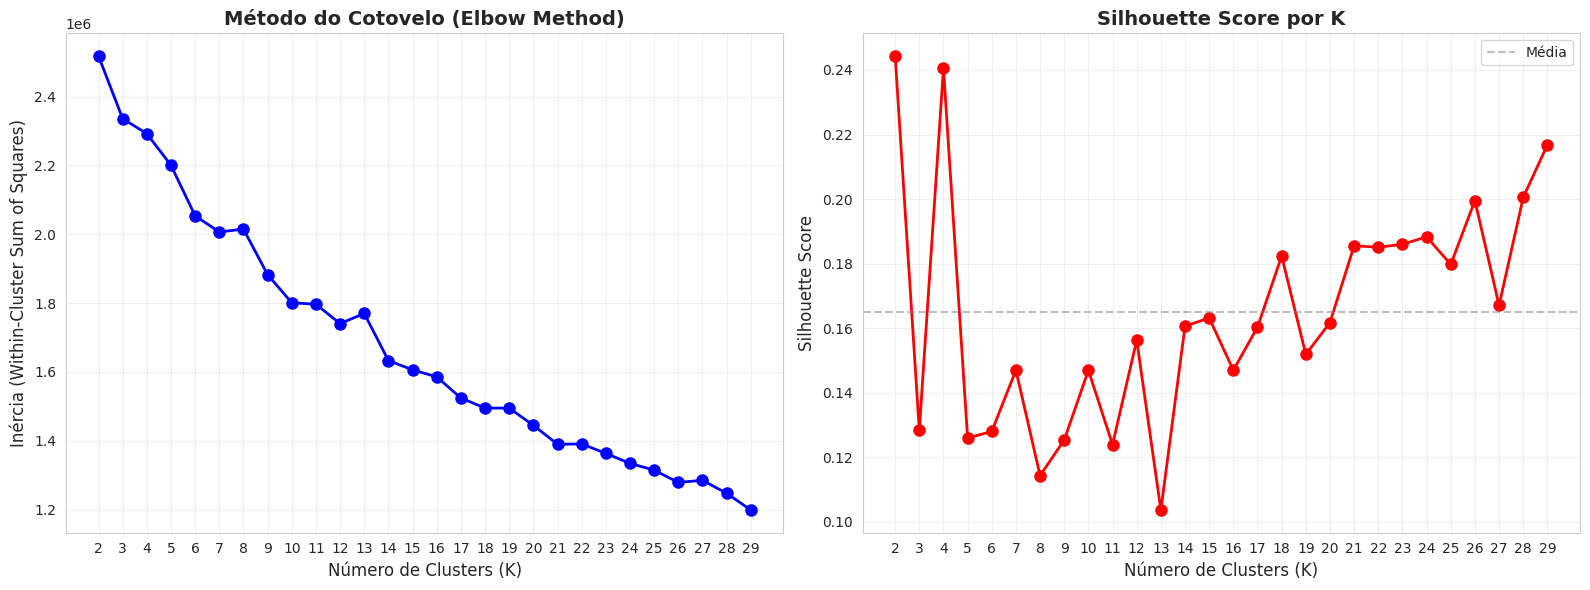


✓ Gráfico salvo: elbow_silhouette_analysis.png


In [144]:
# Visualizar Elbow Method e Silhouette Score
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Elbow Method
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (K)', fontsize=12)
ax1.set_ylabel('Inércia (Within-Cluster Sum of Squares)', fontsize=12)
ax1.set_title('Método do Cotovelo (Elbow Method)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(K_range)

# Silhouette Score
ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (K)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score por K', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(K_range)
ax2.axhline(y=np.mean(silhouette_scores), color='gray', linestyle='--', alpha=0.5, label='Média')
ax2.legend()

plt.tight_layout()
# plt.savefig('elbow_silhouette_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Gráfico salvo: elbow_silhouette_analysis.png")

In [139]:
# Determinar K ótimo baseado no melhor Silhouette Score
K_optimal = K_range[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)

print(f"\n{'='*60}")
print(f"K ÓTIMO RECOMENDADO: {K_optimal}")
print(f"Silhouette Score: {best_silhouette:.4f}")
print(f"{'='*60}")


K ÓTIMO RECOMENDADO: 2
Silhouette Score: 0.2967


## 7. Aplicação do K-Means com K Ótimo

Treinar o modelo final de clusterização e atribuir cada OP ao seu cluster.

In [ ]:

print(f"Treinando K-Means com K={K_optimal}...")
kmeans_final = KMeans(n_clusters=K_optimal, random_state=42, n_init=20)
cluster_labels = kmeans_final.fit_predict(X_scaled)

print(f"\n✓ Modelo treinado com sucesso!")
print(f"  Inércia final: {kmeans_final.inertia_:,.2f}")
print(f"  Iterações: {kmeans_final.n_iter_}")

In [ ]:
# Adicionar labels de cluster ao dataframe original
df_flexo_pedidos['CLUSTER_PRODUTO'] = cluster_labels

# Distribuição dos clusters
print("\nDistribuição dos Clusters:")
print(df_flexo_pedidos['CLUSTER_PRODUTO'].value_counts().sort_index())

In [ ]:
# Visualização da distribuição
fig, ax = plt.subplots(figsize=(10, 6))
cluster_counts = df_flexo_pedidos['CLUSTER_PRODUTO'].value_counts().sort_index()
bars = ax.bar(cluster_counts.index, cluster_counts.values, color=plt.cm.Set3(range(K_optimal)))

ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Quantidade de OPs', fontsize=12)
ax.set_title(f'Distribuição de OPs por Cluster (K={K_optimal})', fontsize=14, fontweight='bold')
ax.set_xticks(range(K_optimal))

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('cluster_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Gráfico salvo: cluster_distribution.png")

In [ ]:
# Salvar modelo e scaler
joblib.dump(kmeans_final, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("\n✓ Modelo salvo: kmeans_model.pkl")
print("✓ Scaler salvo: scaler.pkl")

## 8. Análise de Perfil dos Clusters

Vamos analisar as características predominantes de cada cluster para entender o que os diferencia.

In [ ]:
# Features principais para análise de perfil
features_perfil = [
    'VL_COMPRIMENTO', 'VL_LARGURA', 'VL_ALTURAINTERNA',
    'VL_GRAMATURA', 'QT_NRCORES', 'VL_AREALIQUIDAPECA',
    'VL_MULTCOMP', 'VL_MULTLARG', 'PECAS_POR_CHAPA',
    'QT_VINCOS_TOTAL', 'VL_CONSUMO_COR_TOTAL',
    'VOLUME_INTERNO', 'AREA_CHAPA', 'REFILO_TOTAL'
]

# Estatísticas por cluster
cluster_profiles = df_flexo_pedidos.groupby('CLUSTER_PRODUTO')[features_perfil].agg(['mean', 'median', 'std'])

print("Perfil dos Clusters (médias):")
print("="*100)
cluster_profiles_mean = df_flexo_pedidos.groupby('CLUSTER_PRODUTO')[features_perfil].mean()
print(cluster_profiles_mean.round(2))

In [ ]:
# Salvar perfil completo em CSV
cluster_profiles_mean.to_csv('cluster_profiles.csv')
print("\n✓ Perfil salvo: cluster_profiles.csv")

In [ ]:
# Análise de características categóricas por cluster
print("\n" + "="*100)
print("Características Categóricas por Cluster:")
print("="*100)

categoricas_analise = ['CAT_COMPOSICAO', 'CAT_ESPELHO', 'CAT_FILME', 'TX_TIPOABNT']

for col in categoricas_analise:
    if col in df_flexo_pedidos.columns:
        print(f"\n{col}:")
        crosstab = pd.crosstab(df_flexo_pedidos['CLUSTER_PRODUTO'], 
                               df_flexo_pedidos[col], 
                               normalize='index') * 100
        print(crosstab.round(1))

In [ ]:
# Resumo interpretativo de cada cluster
print("\n" + "="*100)
print("RESUMO INTERPRETATIVO DOS CLUSTERS")
print("="*100)

for cluster_id in range(K_optimal):
    cluster_data = df_flexo_pedidos[df_flexo_pedidos['CLUSTER_PRODUTO'] == cluster_id]
    n_ops = len(cluster_data)
    
    print(f"\n🔹 CLUSTER {cluster_id} ({n_ops:,} OPs - {n_ops/len(df_flexo_pedidos)*100:.1f}%)")
    print("-" * 80)
    
    # Dimensões médias
    comp_med = cluster_data['VL_COMPRIMENTO'].mean()
    larg_med = cluster_data['VL_LARGURA'].mean()
    alt_med = cluster_data['VL_ALTURAINTERNA'].mean()
    print(f"  Dimensões médias: {comp_med:.0f} x {larg_med:.0f} x {alt_med:.0f} mm")
    
    # Gramatura e área
    gram_med = cluster_data['VL_GRAMATURA'].mean()
    area_med = cluster_data['VL_AREALIQUIDAPECA'].mean()
    print(f"  Gramatura média: {gram_med:.0f} g/m²")
    print(f"  Área líquida: {area_med:.3f} m²")
    
    # Cores
    cores_med = cluster_data['QT_NRCORES'].mean()
    consumo_cor = cluster_data['VL_CONSUMO_COR_TOTAL'].mean()
    print(f"  Cores: {cores_med:.1f} cores em média, consumo: {consumo_cor:.0f}")
    
    # Aproveitamento
    pecas_chapa = cluster_data['PECAS_POR_CHAPA'].mean()
    print(f"  Aproveitamento: {pecas_chapa:.1f} peças/chapa em média")
    
    # Composição predominante
    composicao_pred = cluster_data['CAT_COMPOSICAO'].mode()
    if len(composicao_pred) > 0:
        print(f"  Composição predominante: {composicao_pred.iloc[0]}")

## 9. Visualizações dos Clusters

Visualizações para entender a separação e características dos clusters.

### 9.1 PCA - Visualização em 2D

In [ ]:
%%time
# Aplicar PCA para reduzir para 2 dimensões
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Variância explicada pelo PCA:")
print(f"  PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"  PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"  Total: {pca.explained_variance_ratio_.sum()*100:.2f}%")

In [ ]:
# Visualizar clusters em espaço 2D (PCA)
fig, ax = plt.subplots(figsize=(14, 10))

colors = plt.cm.Set3(range(K_optimal))
for cluster_id in range(K_optimal):
    mask = cluster_labels == cluster_id
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=[colors[cluster_id]], 
               label=f'Cluster {cluster_id}',
               alpha=0.6, s=50, edgecolors='gray', linewidth=0.5)

# Adicionar centroides
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
           c='red', marker='X', s=400, edgecolors='black', linewidth=2,
           label='Centroides', zorder=10)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variância)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variância)', fontsize=12)
ax.set_title('Clusters Visualizados em 2D (PCA)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('clusters_pca_2d.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico salvo: clusters_pca_2d.png")

### 9.2 Heatmap - Perfil dos Clusters

In [ ]:
# Normalizar features para heatmap (0-1)
features_heatmap = [
    'VL_COMPRIMENTO', 'VL_LARGURA', 'VL_ALTURAINTERNA',
    'VL_GRAMATURA', 'QT_NRCORES', 'VL_AREALIQUIDAPECA',
    'PECAS_POR_CHAPA', 'QT_VINCOS_TOTAL', 'VL_CONSUMO_COR_TOTAL',
    'VOLUME_INTERNO'
]

# Calcular médias por cluster
cluster_means = df_flexo_pedidos.groupby('CLUSTER_PRODUTO')[features_heatmap].mean()

# Normalizar entre 0-1 para cada feature
minmax = MinMaxScaler()
cluster_means_normalized = pd.DataFrame(
    minmax.fit_transform(cluster_means.T).T,
    index=cluster_means.index,
    columns=cluster_means.columns
)

# Criar heatmap
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(cluster_means_normalized, 
            annot=True, fmt='.2f', 
            cmap='YlOrRd', 
            cbar_kws={'label': 'Valor Normalizado (0-1)'},
            linewidths=0.5, linecolor='gray',
            ax=ax)

ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_title('Heatmap Normalizado dos Clusters (0=mín, 1=máx)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('cluster_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico salvo: cluster_heatmap.png")

### 9.3 Distribuições por Cluster

In [ ]:
# Distribuições das principais features por cluster
features_dist = ['VL_COMPRIMENTO', 'VL_LARGURA', 'VL_GRAMATURA', 'QT_NRCORES', 
                 'PECAS_POR_CHAPA', 'VL_AREALIQUIDAPECA']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(features_dist):
    ax = axes[idx]
    
    for cluster_id in range(K_optimal):
        cluster_data = df_flexo_pedidos[df_flexo_pedidos['CLUSTER_PRODUTO'] == cluster_id][feature]
        ax.hist(cluster_data, bins=30, alpha=0.5, label=f'Cluster {cluster_id}', 
                color=colors[cluster_id])
    
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Frequência', fontsize=10)
    ax.set_title(f'Distribuição: {feature}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cluster_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico salvo: cluster_distributions.png")

## 10. Conclusão e Próximos Passos

In [ ]:
print("="*100)
print("PIPELINE DE CLUSTERIZAÇÃO CONCLUÍDO COM SUCESSO!")
print("="*100)
print(f"\n✓ Dataset processado: {df_flexo_pedidos.shape[0]:,} OPs")
print(f"✓ Features utilizadas: {len(features_clustering)}")
print(f"✓ Número de clusters: {K_optimal}")
print(f"✓ Silhouette Score: {best_silhouette:.4f}")

print("\n📁 Arquivos salvos:")
print("  • kmeans_model.pkl - Modelo K-Means treinado")
print("  • scaler.pkl - StandardScaler para normalização")
print("  • cluster_profiles.csv - Perfil médio de cada cluster")
print("  • elbow_silhouette_analysis.png - Análise do K ótimo")
print("  • cluster_distribution.png - Distribuição de OPs por cluster")
print("  • clusters_pca_2d.png - Visualização PCA 2D")
print("  • cluster_heatmap.png - Heatmap normalizado dos clusters")
print("  • cluster_distributions.png - Distribuições das features")

print("\n📊 Próximos passos sugeridos:")
print("  1. Analisar o perfil de cada cluster para nomear/interpretar")
print("  2. Verificar se há clusters problemáticos (baixa produtividade)")
print("  3. Usar CLUSTER_PRODUTO como feature em modelos supervisionados")
print("  4. Explorar relações entre cluster e métricas de produção")
print("\n" + "="*100)